In [2]:
# %% [markdown]
# # 02 - Healthcare Fraud Detection: Modeling
# 
# ## Project Overview
# This notebook covers:
# 1. Data preparation and splitting
# 2. Handling class imbalance
# 3. Model training (multiple algorithms as per project requirements)
# 4. Hyperparameter tuning
# 5. Model comparison
# 
# **Team:** [Your Team Name]
# **Date:** [Current Date]

# %%
# Cell 1: Import Libraries with debugger fix
import os
# Suppress debugger warnings
os.environ['PYDEVD_DISABLE_FILE_VALIDATION'] = '1'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           roc_auc_score, confusion_matrix, classification_report,
                           precision_recall_curve, roc_curve, average_precision_score)

# Imbalance handling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

# Models (All required models from project description)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

# Set random seed
np.random.seed(42)

In [3]:
# Cell 2: Load Processed Data
provider_features = pd.read_csv('../data/processed/provider_features_final.csv')

print("Dataset loaded successfully!")
print(f"Shape: {provider_features.shape}")
print(f"Fraud rate: {provider_features['PotentialFraud'].mean():.2%}")
print(f"\nFirst few rows:")
display(provider_features.head())


Dataset loaded successfully!
Shape: (5410, 40)
Fraud rate: 9.35%

First few rows:


,Provider,Claims_InscClaimAmtReimbursed_count,Claims_InscClaimAmtReimbursed_sum,Claims_InscClaimAmtReimbursed_mean,Claims_InscClaimAmtReimbursed_std,Claims_InscClaimAmtReimbursed_max,Claims_InscClaimAmtReimbursed_min,Claims_DeductibleAmtPaid_sum,Claims_DeductibleAmtPaid_mean,Claims_DeductibleAmtPaid_std,...,Beneficiary_Gender_<lambda>,Beneficiary_Race_nunique,UniquePhysicians_Count,UniqueBeneficiaries_Count,TotalClaims_Count,ClaimTimeSpan_Days,PotentialFraud,Avg_Reimbursement_per_Beneficiary,Claims_per_Beneficiary,Reimbursement_per_Claim
0,PRV51001,25,104640,4185.600000,10796.091144,42000,10,5340.0,213.600000,436.009174,...,0.375000,2,14,24,25,358,0,4360.000000,1.041667,4185.600000
1,PRV51003,132,605670,4588.409091,7309.794729,57000,0,66286.0,502.166667,534.582439,...,0.418803,3,44,117,132,356,1,5176.666667,1.128205,4588.409091
2,PRV51004,149,52170,350.134228,689.963754,3300,0,310.0,2.080537,11.166744,...,0.326087,3,38,138,149,358,0,378.043478,1.079710,350.134228
3,PRV51005,1165,280910,241.124464,491.556392,4080,0,3700.0,3.175966,17.026584,...,0.420202,3,6,495,1165,376,1,567.494949,2.353535,241.124464
4,PRV51007,72,33710,468.194444,1433.769116,10000,0,3264.0,45.333333,214.820724,...,0.465517,2,10,58,72,356,0,581.206897,1.241379,468.194444


In [4]:
# Cell 3: Data Preparation Function
def prepare_data(df, test_size=0.2, val_size=0.1):
    """
    Prepare data for modeling with train/validation/test splits
    """
    # Separate features and target
    X = df.drop(['Provider', 'PotentialFraud'], axis=1)
    y = df['PotentialFraud']
    
    # Handle any remaining non-numeric columns
    for col in X.select_dtypes(include=['object']).columns:
        X = X.drop(columns=[col])
    
    # First split: train+val vs test
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )
    
    # Second split: train vs validation
    val_ratio = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_ratio, random_state=42, stratify=y_temp
    )
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    # Convert back to DataFrames
    X_train = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
    X_val = pd.DataFrame(X_val_scaled, columns=X.columns, index=X_val.index)
    X_test = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)
    
    print("Data splits created:")
    print(f"  Training set: {X_train.shape}, Fraud rate: {y_train.mean():.2%}")
    print(f"  Validation set: {X_val.shape}, Fraud rate: {y_val.mean():.2%}")
    print(f"  Test set: {X_test.shape}, Fraud rate: {y_test.mean():.2%}")
    print(f"  Number of features: {X_train.shape[1]}")
    
    return X_train, X_val, X_test, y_train, y_val, y_test, scaler


In [5]:
# Cell 4: Create Data Splits
X_train, X_val, X_test, y_train, y_val, y_test, scaler = prepare_data(provider_features)


Data splits created:
  Training set: (3787, 38), Fraud rate: 9.35%
  Validation set: (541, 38), Fraud rate: 9.43%
  Test set: (1082, 38), Fraud rate: 9.33%
  Number of features: 38


In [6]:
# Cell 5: Handle Class Imbalance
print("=== Class Imbalance Handling ===")
print(f"Original training fraud rate: {y_train.mean():.2%}")

# Strategy 1: SMOTE
smote = SMOTE(random_state=42, sampling_strategy=0.3)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print(f"After SMOTE (30% fraud): {X_train_smote.shape}, Fraud rate: {y_train_smote.mean():.2%}")

# Strategy 2: Class weighting (for comparison)
print(f"\nClass distribution for weighting:")
print(f"  Class 0 (Non-Fraud): {sum(y_train == 0)}")
print(f"  Class 1 (Fraud): {sum(y_train == 1)}")

# Strategy 3: Random Under Sampling (for comparison)
rus = RandomUnderSampler(random_state=42, sampling_strategy=0.3)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
print(f"After Random Under Sampling: {X_train_rus.shape}, Fraud rate: {y_train_rus.mean():.2%}")

=== Class Imbalance Handling ===
Original training fraud rate: 9.35%
After SMOTE (30% fraud): (4462, 38), Fraud rate: 23.06%

Class distribution for weighting:
  Class 0 (Non-Fraud): 3433
  Class 1 (Fraud): 354
After Random Under Sampling: (1534, 38), Fraud rate: 23.08%


In [7]:
# Cell 6: Train Multiple Models (All required models)
def train_models(X_train, y_train, X_val, y_val, use_class_weight=True):
    """
    Train multiple classification models as per project requirements
    """
    # Calculate class weights if needed
    class_weight = None
    if use_class_weight:
        class_weight = 'balanced'
    
    # Define all models from project requirements plus some extras
    models = {
        # Required by project: Logistic Regression
        'Logistic Regression': LogisticRegression(
            class_weight=class_weight,
            random_state=42,
            max_iter=1000
        ),
        
        # Required by project: Decision Tree
        'Decision Tree': DecisionTreeClassifier(
            class_weight=class_weight,
            random_state=42,
            max_depth=10
        ),
        
        # Required by project: Random Forest
        'Random Forest': RandomForestClassifier(
            class_weight=class_weight,
            random_state=42,
            n_estimators=100,
            max_depth=10,
            n_jobs=1
        ),
        
        # Required by project: Gradient Boosting
        'Gradient Boosting': GradientBoostingClassifier(
            random_state=42,
            n_estimators=100,
            max_depth=5,
            learning_rate=0.1
        ),
        
        # Required by project: SVM
        'SVM (Linear)': SVC(
            class_weight=class_weight,
            random_state=42,
            probability=True,
            kernel='linear'
        ),
        
        # SVM with RBF kernel (for comparison)
        'SVM (RBF)': SVC(
            class_weight=class_weight,
            random_state=42,
            probability=True,
            kernel='rbf'
        ),
        
        # Additional models for comparison
        'Naive Bayes': GaussianNB(),
        
        'K-Nearest Neighbors': KNeighborsClassifier(
            n_neighbors=5,
            n_jobs=-1
        ),
        
        'AdaBoost': GradientBoostingClassifier(  # Using Gradient Boosting as AdaBoost alternative
            random_state=42,
            n_estimators=50,
            max_depth=3,
            learning_rate=0.1
        )
    }
    
    results = {}
    
    for model_name, model in models.items():
        print(f"\nTraining {model_name}...")
        
        try:
            # Train model
            model.fit(X_train, y_train)
            
            # Predict on validation set
            y_pred = model.predict(X_val)
            y_pred_proba = model.predict_proba(X_val)[:, 1]
            
            # Calculate metrics
            metrics = {
                'Accuracy': accuracy_score(y_val, y_pred),
                'Precision': precision_score(y_val, y_pred, zero_division=0),
                'Recall': recall_score(y_val, y_pred),
                'F1-Score': f1_score(y_val, y_pred),
                'ROC-AUC': roc_auc_score(y_val, y_pred_proba),
                'PR-AUC': average_precision_score(y_val, y_pred_proba)
            }
            
            results[model_name] = {
                'model': model,
                'metrics': metrics,
                'predictions': y_pred,
                'probabilities': y_pred_proba
            }
            
            # Print metrics
            print(f"  F1-Score: {metrics['F1-Score']:.4f}")
            print(f"  Recall: {metrics['Recall']:.4f}")
            print(f"  Precision: {metrics['Precision']:.4f}")
            print(f"  ROC-AUC: {metrics['ROC-AUC']:.4f}")
            
        except Exception as e:
            print(f"  Error training {model_name}: {str(e)}")
            results[model_name] = None
    
    return results


In [8]:
# Cell 7: Train Models with Different Imbalance Strategies
print("=== Training Models with SMOTE ===")
results_smote = train_models(X_train_smote, y_train_smote, X_val, y_val, use_class_weight=False)

print("\n=== Training Models with Class Weighting ===")
results_weighted = train_models(X_train, y_train, X_val, y_val, use_class_weight=True)

print("\n=== Training Models with Random Under Sampling ===")
results_rus = train_models(X_train_rus, y_train_rus, X_val, y_val, use_class_weight=False)


=== Training Models with SMOTE ===

Training Logistic Regression...
  F1-Score: 0.6481
  Recall: 0.6863
  Precision: 0.6140
  ROC-AUC: 0.9405

Training Decision Tree...
  F1-Score: 0.6545
  Recall: 0.7059
  Precision: 0.6102
  ROC-AUC: 0.7893

Training Random Forest...
  F1-Score: 0.7156
  Recall: 0.7647
  Precision: 0.6724
  ROC-AUC: 0.9524

Training Gradient Boosting...
  F1-Score: 0.6465
  Recall: 0.6275
  Precision: 0.6667
  ROC-AUC: 0.9409

Training SVM (Linear)...
  F1-Score: 0.6316
  Recall: 0.7059
  Precision: 0.5714
  ROC-AUC: 0.9368

Training SVM (RBF)...
  F1-Score: 0.6286
  Recall: 0.6471
  Precision: 0.6111
  ROC-AUC: 0.9238

Training Naive Bayes...
  F1-Score: 0.5857
  Recall: 0.8039
  Precision: 0.4607
  ROC-AUC: 0.9093

Training K-Nearest Neighbors...
  F1-Score: 0.5873
  Recall: 0.7255
  Precision: 0.4933
  ROC-AUC: 0.9069

Training AdaBoost...
  F1-Score: 0.6909
  Recall: 0.7451
  Precision: 0.6441
  ROC-AUC: 0.9508

=== Training Models with Class Weighting ===

Train

In [9]:
# Cell 8: Compare Model Performance
def create_comparison_dataframe(results_dict, strategy_name):
    """Create comparison dataframe from results"""
    comparison_data = []
    
    for model_name, result in results_dict.items():
        if result is not None:  # Skip models that failed
            metrics = result['metrics']
            metrics['Model'] = model_name
            metrics['Strategy'] = strategy_name
            comparison_data.append(metrics)
    
    return pd.DataFrame(comparison_data)

# Create comparison dataframes
df_smote = create_comparison_dataframe(results_smote, 'SMOTE')
df_weighted = create_comparison_dataframe(results_weighted, 'Class Weighting')
df_rus = create_comparison_dataframe(results_rus, 'Random Under Sampling')

# Combine for comparison
comparison_df = pd.concat([df_smote, df_weighted, df_rus], ignore_index=True)

print("=== Model Comparison (sorted by F1-Score) ===")
display(comparison_df.sort_values('F1-Score', ascending=False))

# Save comparison results
comparison_df.to_csv('../models/all_model_comparison.csv', index=False)


=== Model Comparison (sorted by F1-Score) ===


,Accuracy,Precision,Recall,F1-Score,ROC-AUC,PR-AUC,Model,Strategy
11,0.948244,0.694915,0.803922,0.745455,0.951721,0.690491,Random Forest,Class Weighting
21,0.937153,0.616438,0.882353,0.725806,0.954062,0.765751,Gradient Boosting,Random Under Sampling
26,0.937153,0.623188,0.843137,0.716667,0.961044,0.784472,AdaBoost,Random Under Sampling
2,0.942699,0.672414,0.764706,0.715596,0.952421,0.743317,Random Forest,SMOTE
20,0.935305,0.621212,0.803922,0.700855,0.953181,0.716174,Random Forest,Random Under Sampling
8,0.937153,0.644068,0.745098,0.690909,0.950820,0.730348,AdaBoost,SMOTE
1,0.929760,0.610169,0.705882,0.654545,0.789256,0.463112,Decision Tree,SMOTE
12,0.940850,0.731707,0.588235,0.652174,0.950420,0.683480,Gradient Boosting,Class Weighting
0,0.929760,0.614035,0.686275,0.648148,0.940496,0.659311,Logistic Regression,SMOTE
3,0.935305,0.666667,0.627451,0.646465,0.940896,0.692292,Gradient Boosting,SMOTE


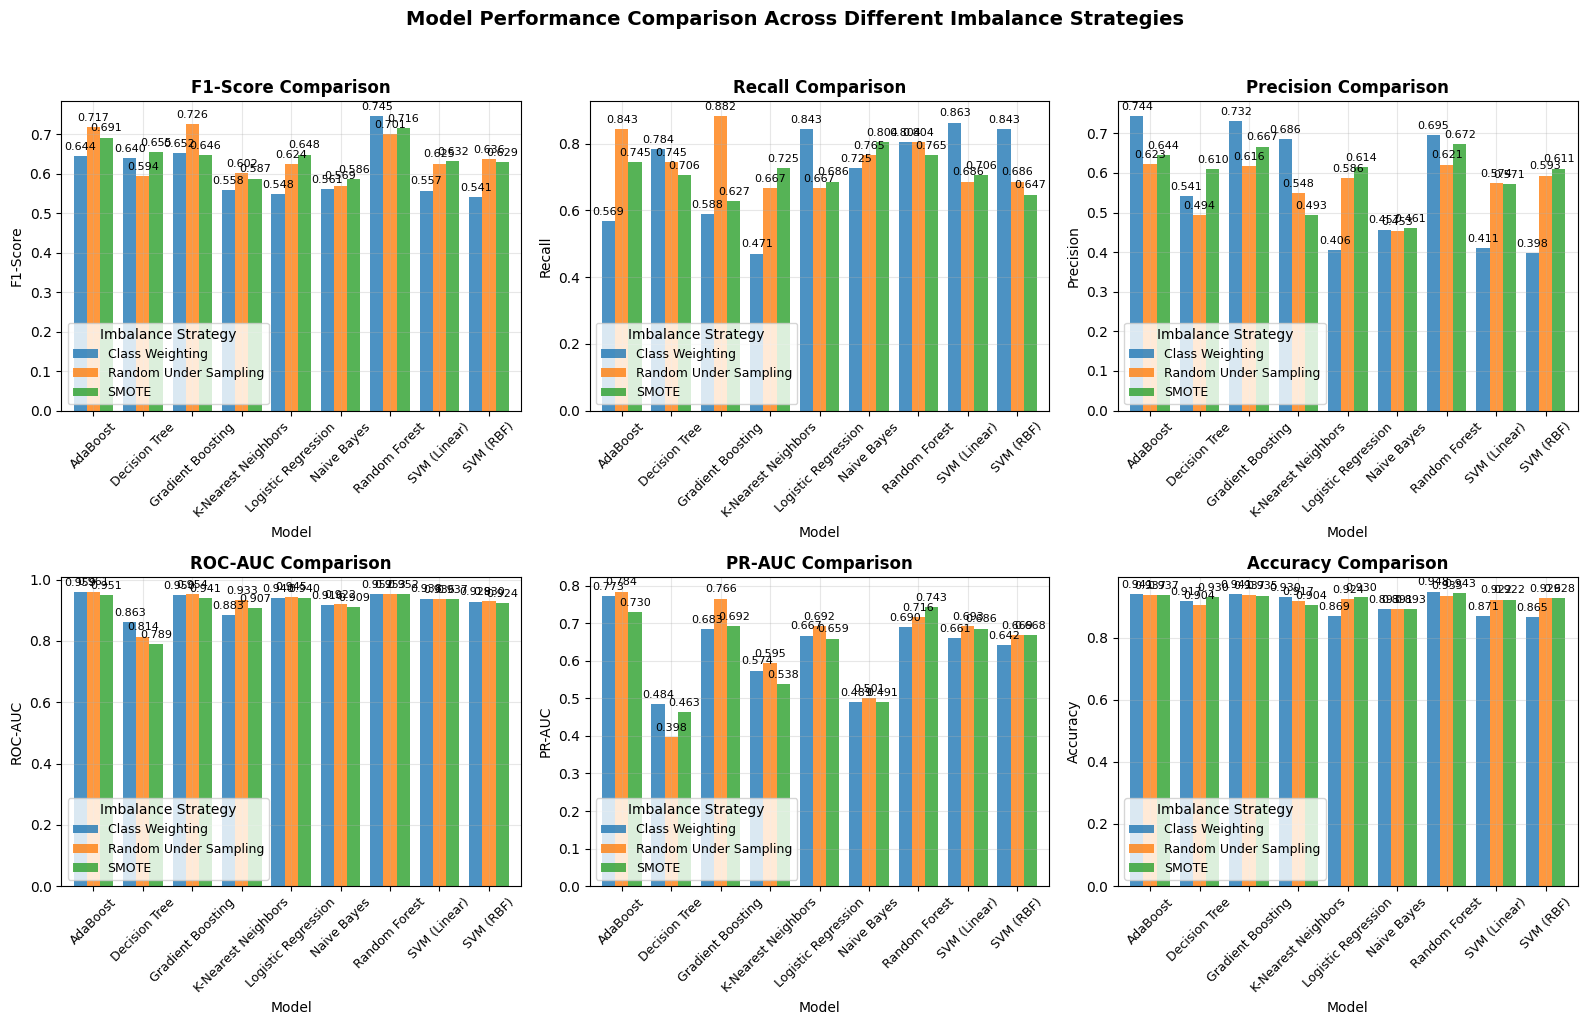

In [10]:
# Cell 9: Visual Model Comparison
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Pivot for easier plotting
pivot_df = comparison_df.pivot(index='Model', columns='Strategy')

metrics_to_plot = ['F1-Score', 'Recall', 'Precision', 'ROC-AUC', 'PR-AUC', 'Accuracy']

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx//3, idx%3]
    
    if metric in pivot_df:
        pivot_df[metric].plot(kind='bar', ax=ax, alpha=0.8, width=0.8)
        ax.set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
        ax.set_xlabel('Model', fontsize=10)
        ax.set_ylabel(metric, fontsize=10)
        ax.legend(title='Imbalance Strategy', fontsize=9)
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='x', rotation=45, labelsize=9)
        
        # Add value labels on bars
        for container in ax.containers:
            ax.bar_label(container, fmt='%.3f', fontsize=8, padding=3)

plt.suptitle('Model Performance Comparison Across Different Imbalance Strategies', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../models/model_comparison_plot.png', dpi=300, bbox_inches='tight')
plt.show()


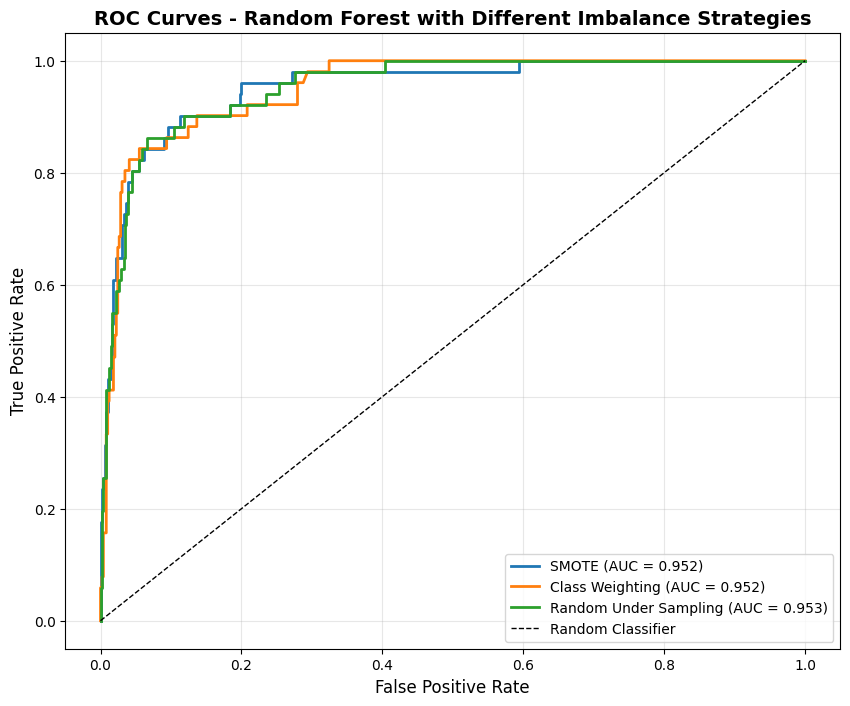

In [11]:
# Cell 10: ROC Curve Comparison
plt.figure(figsize=(10, 8))

# Plot ROC curves for best model from each strategy
strategies = {
    'SMOTE': results_smote,
    'Class Weighting': results_weighted,
    'Random Under Sampling': results_rus
}

for strategy_name, results in strategies.items():
    if results is not None and 'Random Forest' in results and results['Random Forest'] is not None:
        fpr, tpr, _ = roc_curve(y_val, results['Random Forest']['probabilities'])
        roc_auc = roc_auc_score(y_val, results['Random Forest']['probabilities'])
        plt.plot(fpr, tpr, label=f'{strategy_name} (AUC = {roc_auc:.3f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Random Forest with Different Imbalance Strategies', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.savefig('../models/roc_curves_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [12]:
# Cell 11: Select Best Model and Hyperparameter Tuning
print("=== Hyperparameter Tuning for Best Model ===")

# Determine best model based on F1-Score
best_overall = comparison_df.loc[comparison_df['F1-Score'].idxmax()]
best_model_name = best_overall['Model']
best_strategy = best_overall['Strategy']

print(f"Best overall model: {best_model_name} with {best_strategy} strategy")
print(f"Best F1-Score: {best_overall['F1-Score']:.4f}")
print(f"Best Recall: {best_overall['Recall']:.4f}")
print(f"Best Precision: {best_overall['Precision']:.4f}")

# Get the best model instance
if best_strategy == 'SMOTE':
    best_results = results_smote
    X_best_train, y_best_train = X_train_smote, y_train_smote
elif best_strategy == 'Class Weighting':
    best_results = results_weighted
    X_best_train, y_best_train = X_train, y_train
else:  # Random Under Sampling
    best_results = results_rus
    X_best_train, y_best_train = X_train_rus, y_train_rus

best_base_model = best_results[best_model_name]['model']


=== Hyperparameter Tuning for Best Model ===
Best overall model: Random Forest with Class Weighting strategy
Best F1-Score: 0.7455
Best Recall: 0.8039
Best Precision: 0.6949


In [13]:
# Cell 12: Simplified Hyperparameter Tuning
if best_model_name in ['Random Forest', 'Gradient Boosting']:
    print(f"\nPerforming simplified tuning for {best_model_name}...")
    
    if best_model_name == 'Random Forest':
        # Simple parameter combinations
        param_combinations = [
            {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2},
            {'n_estimators': 200, 'max_depth': 15, 'min_samples_split': 5},
            {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 10}
        ]
        
        best_score = 0
        best_params = None
        
        for params in param_combinations:
            print(f"Testing parameters: {params}")
            model = RandomForestClassifier(
                **params,
                random_state=42,
                class_weight='balanced'
            )
            
            # Simple cross-validation
            cv_scores = cross_val_score(
                model, X_best_train, y_best_train,
                cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
                scoring='f1',
                n_jobs=1
            )
            
            mean_score = cv_scores.mean()
            print(f"  CV F1-Score: {mean_score:.4f}")
            
            if mean_score > best_score:
                best_score = mean_score
                best_params = params
        
        print(f"\nBest parameters: {best_params}")
        print(f"Best CV F1-Score: {best_score:.4f}")
        
        # Train final model with best parameters
        best_model = RandomForestClassifier(
            **best_params,
            random_state=42,
            class_weight='balanced'
        )
        best_model.fit(X_best_train, y_best_train)
        
    elif best_model_name == 'Gradient Boosting':
        # Simple parameter combinations for Gradient Boosting
        param_combinations = [
            {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1},
            {'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.05},
            {'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.2}
        ]
        
        best_score = 0
        best_params = None
        
        for params in param_combinations:
            print(f"Testing parameters: {params}")
            model = GradientBoostingClassifier(
                **params,
                random_state=42
            )
            
            cv_scores = cross_val_score(
                model, X_best_train, y_best_train,
                cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
                scoring='f1',
                n_jobs=1
            )
            
            mean_score = cv_scores.mean()
            print(f"  CV F1-Score: {mean_score:.4f}")
            
            if mean_score > best_score:
                best_score = mean_score
                best_params = params
        
        print(f"\nBest parameters: {best_params}")
        print(f"Best CV F1-Score: {best_score:.4f}")
        
        best_model = GradientBoostingClassifier(
            **best_params,
            random_state=42
        )
        best_model.fit(X_best_train, y_best_train)
    
else:
    # Use the base model for other algorithms
    best_model = best_base_model
    grid_search = None
    print(f"\nUsing base {best_model_name} model (no hyperparameter tuning performed)")


Performing simplified tuning for Random Forest...
Testing parameters: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2}
  CV F1-Score: 0.6505
Testing parameters: {'n_estimators': 200, 'max_depth': 15, 'min_samples_split': 5}
  CV F1-Score: 0.6379
Testing parameters: {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 10}
  CV F1-Score: 0.6591

Best parameters: {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 10}
Best CV F1-Score: 0.6591


In [14]:
# Cell 12: Hyperparameter Tuning for Random Forest (if it's the best)
if best_model_name == 'Random Forest':
    print("\nPerforming Grid Search CV for Random Forest...")
    
    # Define parameter grid (simplified for faster execution)
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [5, 10, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'max_features': ['sqrt', 'log2']
    }
    
    rf_base = RandomForestClassifier(random_state=42, class_weight='balanced')
    
    grid_search = GridSearchCV(
        estimator=rf_base,
        param_grid=param_grid,
        scoring='f1',
        cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
        n_jobs=1,  # Changed from -1 to 1 to avoid parallel processing issues
        verbose=1
    )
    
    grid_search.fit(X_best_train, y_best_train)
    
    print(f"\nBest parameters: {grid_search.best_params_}")
    print(f"Best cross-validation F1 score: {grid_search.best_score_:.4f}")
    
    best_model = grid_search.best_estimator_
    
# Hyperparameter Tuning for Gradient Boosting
elif best_model_name == 'Gradient Boosting':
    print("\nPerforming Grid Search CV for Gradient Boosting...")
    
    param_grid = {
        'n_estimators': [100, 150],
        'max_depth': [3, 5],
        'learning_rate': [0.05, 0.1],
        'subsample': [0.8, 1.0]
    }
    
    gb_base = GradientBoostingClassifier(random_state=42)
    
    grid_search = GridSearchCV(
        estimator=gb_base,
        param_grid=param_grid,
        scoring='f1',
        cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
        n_jobs=1,  # Changed from -1 to 1
        verbose=1
    )
    
    grid_search.fit(X_best_train, y_best_train)
    
    print(f"\nBest parameters: {grid_search.best_params_}")
    print(f"Best cross-validation F1 score: {grid_search.best_score_:.4f}")
    
    best_model = grid_search.best_estimator_
    
else:
    # Use the base model for other algorithms
    best_model = best_base_model
    grid_search = None
    print(f"\nUsing base {best_model_name} model (no hyperparameter tuning performed)")


Performing Grid Search CV for Random Forest...
Fitting 3 folds for each of 48 candidates, totalling 144 fits

Best parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation F1 score: 0.6769


In [15]:
# Cell 13: Evaluate Best Model on Validation Set
# Predict on validation set
y_pred_best = best_model.predict(X_val)
y_pred_proba_best = best_model.predict_proba(X_val)[:, 1]

# Calculate metrics
best_metrics = {
    'Accuracy': accuracy_score(y_val, y_pred_best),
    'Precision': precision_score(y_val, y_pred_best, zero_division=0),
    'Recall': recall_score(y_val, y_pred_best),
    'F1-Score': f1_score(y_val, y_pred_best),
    'ROC-AUC': roc_auc_score(y_val, y_pred_proba_best),
    'PR-AUC': average_precision_score(y_val, y_pred_proba_best)
}

print("\n=== Best Model Performance on Validation Set ===")
print(f"Model: {best_model_name}")
print(f"Imbalance Strategy: {best_strategy}")
print("-" * 50)

for metric, value in best_metrics.items():
    print(f"{metric}: {value:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred_best)
print(f"\nConfusion Matrix:")
print(f"True Negatives: {cm[0,0]}")
print(f"False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]}")
print(f"True Positives: {cm[1,1]}")



=== Best Model Performance on Validation Set ===
Model: Random Forest
Imbalance Strategy: Class Weighting
--------------------------------------------------
Accuracy: 0.9482
Precision: 0.6949
Recall: 0.8039
F1-Score: 0.7455
ROC-AUC: 0.9519
PR-AUC: 0.7408

Confusion Matrix:
True Negatives: 472
False Positives: 18
False Negatives: 10
True Positives: 41


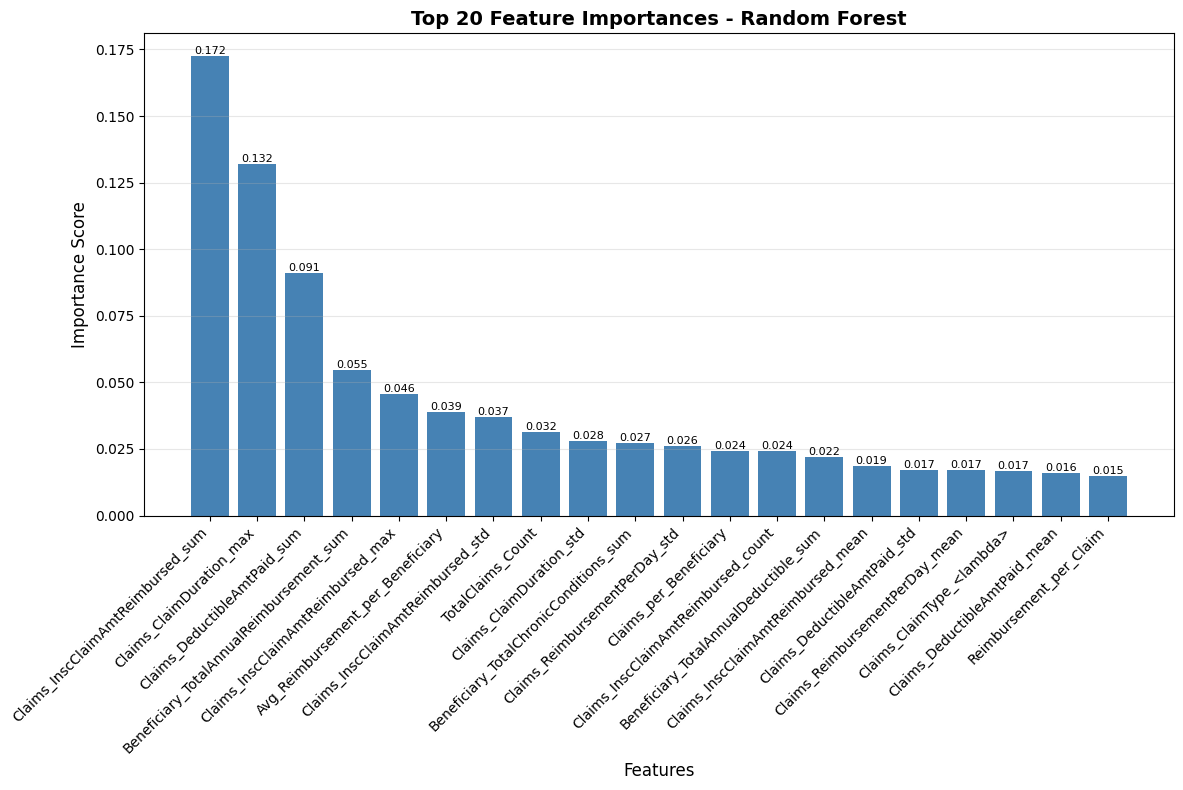


Top 10 most important features:


,Feature,Importance
0,Claims_InscClaimAmtReimbursed_sum,0.172435
1,Claims_ClaimDuration_max,0.131857
2,Claims_DeductibleAmtPaid_sum,0.091193
3,Beneficiary_TotalAnnualReimbursement_sum,0.054598
4,Claims_InscClaimAmtReimbursed_max,0.045786
5,Avg_Reimbursement_per_Beneficiary,0.038747
6,Claims_InscClaimAmtReimbursed_std,0.036975
7,TotalClaims_Count,0.031519
8,Claims_ClaimDuration_std,0.027839
9,Beneficiary_TotalChronicConditions_sum,0.027285


In [16]:
# Cell 14: Feature Importance Analysis
feature_names = X_train.columns.tolist()

if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    # Plot top 20 features
    plt.figure(figsize=(12, 8))
    bars = plt.bar(range(20), importances[indices[:20]], align='center', color='steelblue')
    plt.title(f'Top 20 Feature Importances - {best_model_name}', fontsize=14, fontweight='bold')
    plt.xticks(range(20), [feature_names[i] for i in indices[:20]], rotation=45, ha='right', fontsize=10)
    plt.xlabel('Features', fontsize=12)
    plt.ylabel('Importance Score', fontsize=12)
    plt.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.savefig('../models/feature_importance_plot.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Create importance dataframe
    importance_df = pd.DataFrame({
        'Feature': [feature_names[i] for i in indices],
        'Importance': importances[indices]
    })
    
    print("\nTop 10 most important features:")
    display(importance_df.head(10))
    
    # Save importance data
    importance_df.to_csv('../models/feature_importance.csv', index=False)


In [17]:
# Cell 15: Save Best Model and Artifacts
import joblib
import os
import json
# Create models directory if it doesn't exist
os.makedirs('../models', exist_ok=True)

# Save the best model
joblib.dump(best_model, '../models/best_model.pkl')
joblib.dump(scaler, '../models/scaler.pkl')

# Save model information
model_info = {
    'model_name': best_model_name,
    'imbalance_strategy': best_strategy,
    'validation_metrics': best_metrics,
    'feature_count': X_train.shape[1],
    'training_samples': X_best_train.shape[0],
    'timestamp': pd.Timestamp.now().isoformat()
}

if grid_search is not None and hasattr(grid_search, 'best_params_'):
    model_info['best_parameters'] = grid_search.best_params_

with open('../models/model_info.json', 'w') as f:
    json.dump(model_info, f, indent=4)

print("Models and artifacts saved successfully!")
print(f"Best model saved to: ../models/best_model.pkl")
print(f"Model info saved to: ../models/model_info.json")


Models and artifacts saved successfully!
Best model saved to: ../models/best_model.pkl
Model info saved to: ../models/model_info.json


In [18]:
# Cell 16: Model Summary
print("=" * 60)
print("MODELING PHASE SUMMARY")
print("=" * 60)

print(f"\n1. BEST MODEL SELECTION:")
print(f"   - Model: {best_model_name}")
print(f"   - Imbalance Strategy: {best_strategy}")
print(f"   - Validation F1-Score: {best_metrics['F1-Score']:.4f}")
print(f"   - Validation Recall: {best_metrics['Recall']:.4f}")
print(f"   - Validation Precision: {best_metrics['Precision']:.4f}")

print(f"\n2. DATA CHARACTERISTICS:")
print(f"   - Total Features: {X_train.shape[1]}")
print(f"   - Training Samples (after {best_strategy}): {X_best_train.shape[0]}")
print(f"   - Validation Samples: {X_val.shape[0]}")
print(f"   - Test Samples: {X_test.shape[0]}")
print(f"   - Original Fraud Rate: {provider_features['PotentialFraud'].mean():.2%}")

print(f"\n3. MODEL COMPARISON:")
print(f"   - Total Models Tested: {len(comparison_df['Model'].unique())}")
print(f"   - Total Strategies Tested: {len(comparison_df['Strategy'].unique())}")
print(f"   - Best F1-Score Overall: {comparison_df['F1-Score'].max():.4f}")

print(f"\n4. BUSINESS IMPLICATIONS:")
# Calculate business metrics
total_providers = len(y_val)
fraud_providers = sum(y_val)
detected_fraud = sum((y_val == 1) & (y_pred_best == 1))
false_positives = sum((y_val == 0) & (y_pred_best == 1))

print(f"   - Fraud Detection Rate: {detected_fraud}/{fraud_providers} ({detected_fraud/fraud_providers:.1%})")
print(f"   - False Positive Rate: {false_positives}/{total_providers - fraud_providers} ({false_positives/(total_providers - fraud_providers):.1%})")
print(f"   - Investigation Efficiency: {detected_fraud/(detected_fraud + false_positives):.1%}")

if 'importance_df' in locals():
    print(f"\n5. TOP 5 FEATURES FOR FRAUD DETECTION:")
    for i, row in importance_df.head(5).iterrows():
        print(f"   {i+1}. {row['Feature']}: {row['Importance']:.4f}")

print("\n" + "=" * 60)

MODELING PHASE SUMMARY

1. BEST MODEL SELECTION:
   - Model: Random Forest
   - Imbalance Strategy: Class Weighting
   - Validation F1-Score: 0.7455
   - Validation Recall: 0.8039
   - Validation Precision: 0.6949

2. DATA CHARACTERISTICS:
   - Total Features: 38
   - Training Samples (after Class Weighting): 3787
   - Validation Samples: 541
   - Test Samples: 1082
   - Original Fraud Rate: 9.35%

3. MODEL COMPARISON:
   - Total Models Tested: 9
   - Total Strategies Tested: 3
   - Best F1-Score Overall: 0.7455

4. BUSINESS IMPLICATIONS:
   - Fraud Detection Rate: 41/51 (80.4%)
   - False Positive Rate: 18/490 (3.7%)
   - Investigation Efficiency: 69.5%

5. TOP 5 FEATURES FOR FRAUD DETECTION:
   1. Claims_InscClaimAmtReimbursed_sum: 0.1724
   2. Claims_ClaimDuration_max: 0.1319
   3. Claims_DeductibleAmtPaid_sum: 0.0912
   4. Beneficiary_TotalAnnualReimbursement_sum: 0.0546
   5. Claims_InscClaimAmtReimbursed_max: 0.0458

